# Overview
In this notebook we load the data and view different images to get a better idea about the challenge we are facing. This is always a very helpful first step. It is also important that you can see and try to make some of your own predictions about the data. If you cannot see differences between the groups it is going to be difficult for a biomarker to capture that (but not necessarily impossible)

Install the PyRadiomics package read more about it here (https://pyradiomics.readthedocs.io/en/latest/)

In [1]:
# special functions for using pyradiomics
from SimpleITK import GetImageFromArray
import radiomics
from radiomics.featureextractor import RadiomicsFeatureExtractor # This module is used for interaction with pyradiomic
import logging
logging.getLogger('radiomics').setLevel(logging.CRITICAL + 1)  # this tool makes a whole TON of log noise

### Setup the PyRadiomics Code

In [2]:
# Instantiate the extractor
texture_extractor = RadiomicsFeatureExtractor(verbose=False)
texture_extractor.disableAllFeatures()
_text_feat = {ckey: [] for ckey in texture_extractor.featureClassNames}
texture_extractor.enableFeaturesByName(**_text_feat)

print('Extraction parameters:\n\t', texture_extractor.settings)
print('Enabled filters:\n\t', texture_extractor.enabledImagetypes) 
print('Enabled features:\n\t', texture_extractor.enabledFeatures) 

Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'verbose': False}
Enabled filters:
	 {'Original': {}}
Enabled features:
	 {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': [], 'shape2D': []}


In [3]:
import numpy as np # for manipulating 3d images
import pandas as pd # for reading and writing tables
import h5py # for reading the image files
import skimage # for image processing and visualizations
import sklearn # for machine learning and statistical models
import os # help us load files and deal with paths
from pathlib import Path # help manage files
import glob
import cv2

### Plot Setup Code
Here we setup the defaults to make the plots look a bit nicer for the notebook

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

# Load the Training Data
We start with the training data since we have labels for them and can look in more detail

In [6]:
train_df=pd.read_csv('D:\\Final Semester Project\\Final Dataset\\Tomato Yellow Leaf Curl Virus\\Train.csv')
#train_df = pd.read_csv('../input/train.csv')
train_df.head(10) # show the first 5 lines

,scan_id,h5_path
0,1000,Yellow_leaf_1000.jpg
1,1001,Yellow_leaf_1001.jpg
2,1002,Yellow_leaf_1002.jpg
3,1003,Yellow_leaf_1003.jpg
4,1004,Yellow_leaf_1004.jpg
5,1005,Yellow_leaf_1005.jpg
6,1006,Yellow_leaf_1006.jpg
7,1007,Yellow_leaf_1007.jpg
8,1008,Yellow_leaf_1008.jpg
9,1009,Yellow_leaf_1009.jpg


# Read Image

In [7]:
  def read_scan(in_filename, folder='Tomato Yellow Leaf Curl Virus'):
    full_scan_path = os.path.join('D:\\Final Semester Project\\Final Dataset\\Tomato Yellow Leaf Curl Virus', in_filename)
    # load the image using jpg
    data=str(full_scan_path)
    images=cv2.imread(data)
    return images

# Load a Scan
- the data on kaggle are located in a parent folder called input. 
- Since the files have been organized into train and test we use the train folder

In [8]:
sample_scan = train_df.iloc[0] # just take the first row
print(sample_scan)
image_data = read_scan(sample_scan['h5_path'])
print('Image Shape:', image_data.shape)

scan_id                    1000
h5_path    Yellow_leaf_1000.jpg
Name: 0, dtype: object
Image Shape: (256, 256, 3)


In [9]:
type(image_data)

numpy.ndarray

# Calculate Radiomic Features
Calculate the radiomic features for the test scan

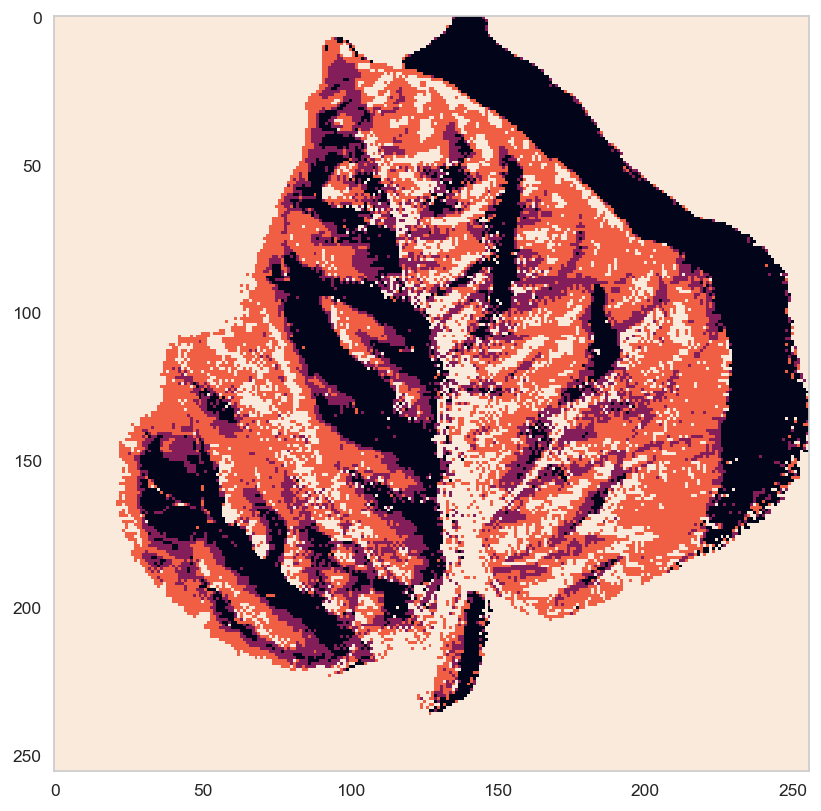

In [10]:
# we take a mask by just keeping the part of the image greater than 0
plt.imshow(np.sum((image_data>60).astype(float), -1))

In [11]:
%%time
results = texture_extractor.execute(GetImageFromArray(image_data),
                            GetImageFromArray((image_data>0).astype(np.uint8)))

Wall time: 45.9 s


In [12]:
pd.DataFrame([results]).T

,0
diagnostics_Versions_PyRadiomics,v3.0
diagnostics_Versions_Numpy,1.18.1
diagnostics_Versions_SimpleITK,1.2.4
diagnostics_Versions_PyWavelet,1.0.0
diagnostics_Versions_Python,3.7.6
...,...
original_ngtdm_Busyness,340.9227619628543
original_ngtdm_Coarseness,4.7638227159290544e-05
original_ngtdm_Complexity,41.693748386401374
original_ngtdm_Contrast,0.05737594813793526


In [13]:
def calc_radiomics(in_image_data):
    return texture_extractor.execute(GetImageFromArray(in_image_data),
                            GetImageFromArray((in_image_data>0).astype(np.uint8)))

### Run over all scans
We use the `.map` function from pandas to calculate the brightness for all the scans

In [14]:
%%time
train_df['radiomics'] = train_df['h5_path'].map(lambda c_filename: calc_radiomics(read_scan(c_filename)))

Wall time: 7min 11s


In [15]:
new_train_df = pd.DataFrame([dict(**c_row.pop('radiomics'), **c_row) for _, c_row in train_df.iterrows()])
print(new_train_df.shape, 'data prepared')
first_cols = new_train_df.columns[:-1].tolist()
new_train_df = new_train_df[first_cols + [c_col for c_col in new_train_df.columns 
                                if c_col not in first_cols]]
# export the whole table
new_train_df.to_csv('D:\\Final Semester Project\\Final Dataset\\Tomato Yellow Leaf Curl Virus\\all_radiomics_table1.csv', index=False)
new_train_df.sample(10)

(10, 131) data prepared


,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,scan_id,h5_path
3,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},2b61bc8602ec7df56583c2054c42086548bc35ab,3D,"(1.0, 1.0, 1.0)",...,6.711675365158717,0.00401878144442127,16024913.919758052,263.1608051490924,6.624736367895675e-05,15.107483234088125,0.021849299414833274,0.0014610255221484737,1003,Yellow_leaf_1003.jpg
7,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},d0b3d4fae842ee23267a6025c135dd232f1c01d2,3D,"(1.0, 1.0, 1.0)",...,5.4760616905554445,0.018172750543248704,2460339.4016551552,360.5309278315373,5.612927715121919e-05,11.984900084568169,0.03373198726088938,0.0013076876190138205,1007,Yellow_leaf_1007.jpg
6,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},624f69fd0eb236fb828c5d563ff94a26e4338d91,3D,"(1.0, 1.0, 1.0)",...,5.632849387279107,0.03340144408379151,716639.6485841274,455.3411254411982,5.577645339190351e-05,20.285170523101467,0.054345810966600724,0.0015368150850332838,1006,Yellow_leaf_1006.jpg
2,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},f35ef3ef6952ff8a7b7ba7dd6e30ec7363d776f5,3D,"(1.0, 1.0, 1.0)",...,5.919245007745488,0.05423871610722395,238048.17291292854,288.56585409919927,5.5013067745088554e-05,36.35330038556633,0.08042038631712314,0.002319872659992006,1002,Yellow_leaf_1002.jpg
5,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},7aa12e4151bfdb12bc69d29da82d1c70e10acf9e,3D,"(1.0, 1.0, 1.0)",...,5.833131518350042,0.04738388159914843,347220.59384651517,276.90468278796715,5.842046067808803e-05,33.549439758905926,0.060679473992725656,0.0024919818252243367,1005,Yellow_leaf_1005.jpg
9,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},fe5133e8e168dc59b900217b63258a9a59f9f7bc,3D,"(1.0, 1.0, 1.0)",...,6.648075519918283,0.010128308877793556,2463257.5112115857,333.13164106271137,4.613384292764105e-05,31.484097978785723,0.05619790184123321,0.00148628163496479,1009,Yellow_leaf_1009.jpg
0,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},04497e6ed229235fbc6687e1787beb3701e89188,3D,"(1.0, 1.0, 1.0)",...,5.607164020836806,0.03278570916134586,587431.0402457551,340.9227619628543,4.7638227159290544e-05,41.693748386401374,0.05737594813793526,0.0024060714817552738,1000,Yellow_leaf_1000.jpg
8,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},dcd0a8e589008dede2f83f28f34837212d4a7c05,3D,"(1.0, 1.0, 1.0)",...,6.797635299012453,0.007234665211916039,7520430.955731661,256.3634449671159,7.099139387421571e-05,19.158123607653753,0.015740694057047772,0.002590070338453099,1008,Yellow_leaf_1008.jpg
4,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},a7a6a1cad9eaf2d895bf994456fa506a66634183,3D,"(1.0, 1.0, 1.0)",...,5.6921048375530106,0.03929787657699514,533562.2281872187,470.34647248960437,5.1753534748829457e-05,21.711241091897506,0.05262884722124263,0.0013367548977370424,1004,Yellow_leaf_1004.jpg
1,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},173b43a65db57ab2fdffebd66261b68e1b312b38,3D,"(1.0, 1.0, 1.0)",...,5.990289977061357,0.04366441421855738,281150.011823772,303.1826852714632,6.362501987847774e-05,32.2

In [16]:
from numpy.random import RandomState
df = pd.read_csv('D:\\Final Semester Project\\Final Dataset\\Tomato Yellow Leaf Curl Virus\\all_radiomics_table1.csv')
rng = RandomState()
train = df.sample(frac=0.7, random_state=rng) #70% traning data
test = df.loc[~df.index.isin(train.index)]  #30% test data

In [17]:
print(train,test)

  diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
9                             v3.0                     1.18.1   
6                             v3.0                     1.18.1   
4                             v3.0                     1.18.1   
2                             v3.0                     1.18.1   
8                             v3.0                     1.18.1   
3                             v3.0                     1.18.1   
5                             v3.0                     1.18.1   

  diagnostics_Versions_SimpleITK diagnostics_Versions_PyWavelet  \
9                          1.2.4                          1.0.0   
6                          1.2.4                          1.0.0   
4                          1.2.4                          1.0.0   
2                          1.2.4                          1.0.0   
8                          1.2.4                          1.0.0   
3                          1.2.4                          1.0.0   
5         

In [18]:
train.to_csv('D:\\Final Semester Project\\Final Dataset\\Tomato Yellow Leaf Curl Virus\\train_data.csv', index=False)
train.sample(7)

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,scan_id,h5_path
9,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},fe5133e8e168dc59b900217b63258a9a59f9f7bc,3D,"(1.0, 1.0, 1.0)",...,6.648076,0.010128,2.463258e+06,333.131641,0.000046,31.484098,0.056198,0.001486,1009,Yellow_leaf_1009.jpg
8,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},dcd0a8e589008dede2f83f28f34837212d4a7c05,3D,"(1.0, 1.0, 1.0)",...,6.797635,0.007235,7.520431e+06,256.363445,0.000071,19.158124,0.015741,0.002590,1008,Yellow_leaf_1008.jpg
5,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},7aa12e4151bfdb12bc69d29da82d1c70e10acf9e,3D,"(1.0, 1.0, 1.0)",...,5.833132,0.047384,3.472206e+05,276.904683,0.000058,33.549440,0.060679,0.002492,1005,Yellow_leaf_1005.jpg
4,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},a7a6a1cad9eaf2d895bf994456fa506a66634183,3D,"(1.0, 1.0, 1.0)",...,5.692105,0.039298,5.335622e+05,470.346472,0.000052,21.711241,0.052629,0.001337,1004,Yellow_leaf_1004.jpg
3,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},2b61bc8602ec7df56583c2054c42086548bc35ab,3D,"(1.0, 1.0, 1.0)",...,6.711675,0.004019,1.602491e+07,263.160805,0.000066,15.107483,0.021849,0.001461,1003,Yellow_leaf_1003.jpg
2,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},f35ef3ef6952ff8a7b7ba7dd6e30ec7363d776f5,3D,"(1.0, 1.0, 1.0)",...,5.919245,0.054239,2.380482e+05,288.565854,0.000055,36.353300,0.080420,0.002320,1002,Yellow_leaf_1002.jpg
6,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},624f69fd0eb236fb828c5d563ff94a26e4338d91,3D,"(1.0, 1.0, 1.0)",...,5.632849,0.033401,7.166396e+05,455.341125,0.000056,20.285171,0.054346,0.001537,1006,Yellow_leaf_1006.jpg


In [19]:
test.to_csv('D:\\Final Semester Project\\Final Dataset\\Tomato Yellow Leaf Curl Virus\\test_data.csv', index=False)
test.sample(3)

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,scan_id,h5_path
7,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},d0b3d4fae842ee23267a6025c135dd232f1c01d2,3D,"(1.0, 1.0, 1.0)",...,5.476062,0.018173,2.460339e+06,360.530928,0.000056,11.984900,0.033732,0.001308,1007,Yellow_leaf_1007.jpg
0,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},04497e6ed229235fbc6687e1787beb3701e89188,3D,"(1.0, 1.0, 1.0)",...,5.607164,0.032786,5.874310e+05,340.922762,0.000048,41.693748,0.057376,0.002406,1000,Yellow_leaf_1000.jpg
1,v3.0,1.18.1,1.2.4,1.0.0,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},173b43a65db57ab2fdffebd66261b68e1b312b38,3D,"(1.0, 1.0, 1.0)",...,5.990290,0.043664,2.811500e+05,303.182685,0.000064,32.232720,0.080202,0.002680,1001,Yellow_leaf_1001.jpg
